<a href="https://colab.research.google.com/github/emil-meyknecht/model_fittinng_cogMod/blob/main/Model_fitting_notebook_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Tutorial on model fitting by Anne Urai, Leiden University (2021).

Based on a tutorial on computational modeling and statistical model fitting as a part the *Trends in Computational Neuroscience* graduate course of the University of Geneva (March-April 2020) by [Luigi Acerbi](http://luigiacerbi.com/).

**Instructions:** 
- In [Google Colab](https://colab.research.google.com/), open the link to this Jupyter notebook
    - To run this notebook locally, you will need standard scientific Python 3.x installation with Jupyter notebook (such as [Anaconda](https://www.anaconda.com/distribution/)). 
- You will also need the `CMA-ES` optimization algorithm (see [here](https://github.com/CMA-ES/pycma)). You can install CMA-ES from the command line with `pip install cma`.
    - In Google Colab, do this by adding a cell with `%pip install cma` before importing.

**Initial setup and loading the data:**

In [10]:
# for running in Google Colab
%pip install cma 

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy.stats import norm
import cma

During this tutorial, we are going to use data from the [International Brain Laboratory](https://www.internationalbrainlab.com/) publicly released behavioral mouse dataset, from exemplar mouse `KS014`. See [this paper](https://elifesciences.org/articles/63711) for more information about the task and datasets. These data can also be inspected via the IBL DataJoint public interface [here](https://data.internationalbrainlab.org/mouse/18a54f60-534b-4ed5-8bda-b434079b8ab8).

For convenience, the data of all behavioral sessions from examplar mouse `KS014` have been already downloaded in the `data` folder and slightly preprocessed into two `.csv` files, one for the training sessions (`KS014_train.csv`) and one with the *biased* sessions (`KS014_biased.csv`). 

We begin our tutorial by examining the training sessions. 

In [12]:
df = pd.read_csv('https://raw.githubusercontent.com/anne-urai/tics-2020-tutorial/master/data/KS014_train.csv')  # Load .csv file into a pandas DataFrame

df['signed_contrast'] = df['contrast']*df['position']   # We define a new column for "signed contrasts"
df.drop(columns='stim_probability_left', inplace=True)  # Stimulus probability has no meaning for training sessions

print('Total # of trials: ' + str(len(df['trial_num'])))
print('Sessions: ' + str(np.unique(df['session_num'])))
df.head()

Total # of trials: 10310
Sessions: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


,trial_num,session_num,contrast,position,response_choice,trial_correct,reaction_time,signed_contrast
0,1,1,100.0,-1.0,-1,1.0,1.052300,-100.0
1,2,1,50.0,1.0,1,1.0,0.276001,50.0
2,3,1,50.0,1.0,-1,0.0,2.094101,50.0
3,4,1,50.0,-1.0,1,0.0,3.407901,-50.0
4,5,1,50.0,1.0,1,1.0,1.601400,50.0


**Inspecting the data:**

The first thing to do with any dataset is to get familiar with it by running simple visualizations. Just plot stuff!
For example, as a starter we plot data from individual sessions using a *scatterplot* format (perhaps not the best). What can we see from here?

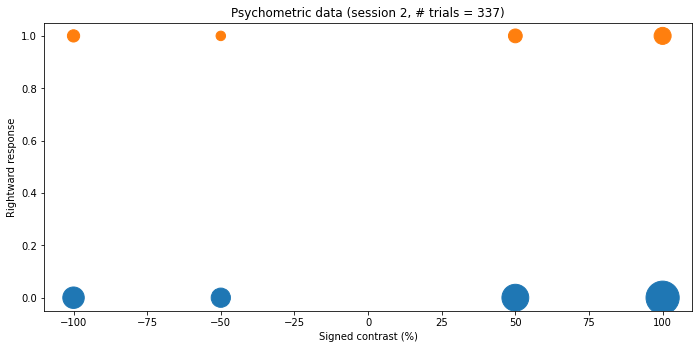

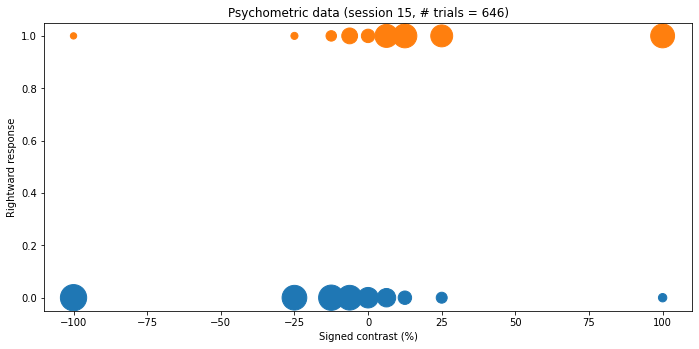

In [13]:
def scatterplot_psychometric_data(df,session_num=None,ax=None):
    """Plot psychometric data (optionally, of a chosen training session) as a scatter plot."""
    
    if session_num == None:
        trial_mask = np.ones(len(df['session_num']), dtype=bool) # Select all trials
    else:
        trial_mask = df['session_num'] == session_num # Indexes of trials of the chosen session
    Ntrials = np.sum(trial_mask) # Number of chosen trials
    
    # Count "left" and "right" responses for each signed contrast level
    left_resp = df[(df['response_choice'] == -1) & trial_mask].groupby(['signed_contrast']).count()['trial_num']
    right_resp = df[(df['response_choice'] == 1) & trial_mask].groupby(['signed_contrast']).count()['trial_num']    
    
    if ax == None:
        ax=fig.add_axes([0,0,1,1])
    ax.scatter(left_resp.index,np.zeros(len(left_resp.index)), s=left_resp*10);
    ax.scatter(right_resp.index,np.ones(len(right_resp.index)), s=right_resp*10);
    ax.set_xlabel('Signed contrast (%)')
    ax.set_ylabel('Rightward response')
    if session_num == None:
        ax.set_title('Psychometric data (# trials = ' + str(Ntrials) + ')')        
    else:
        ax.set_title('Psychometric data (session ' + str(session_num) + ', # trials = ' + str(Ntrials) + ')')        
    return ax

# Plot 2nd session
fig = plt.figure(figsize=(9,4))
scatterplot_psychometric_data(df,2)
plt.show()

# Plot 15th session (last training session)
fig = plt.figure(figsize=(9,4))
scatterplot_psychometric_data(df,15)
plt.show()

We plot the same data again, this time with a different type of plot which may be more informative.

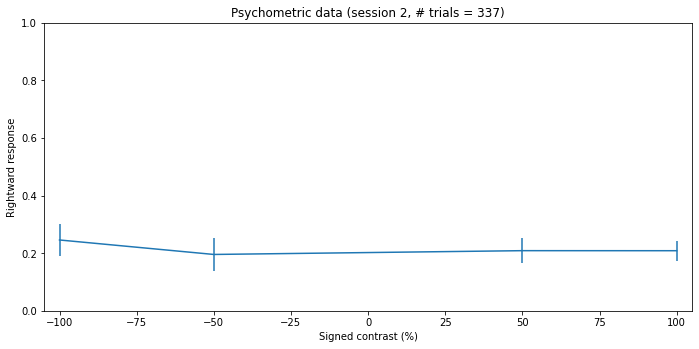

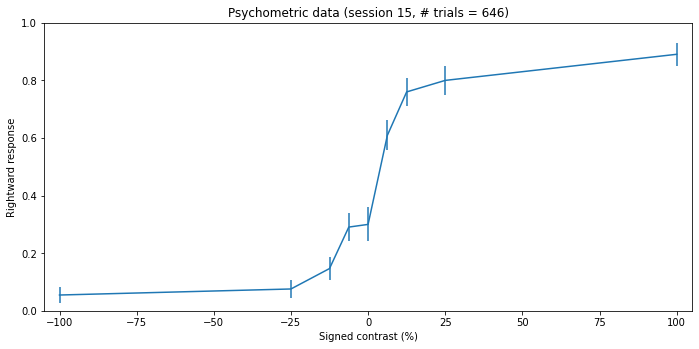

In [14]:
def plot_psychometric_data(df,session_num=None,ax=None):
    """Plot psychometric data (optionally, of a chosen training session) as a scatter plot."""
    
    if session_num == None:
        trial_mask = np.ones(len(df['session_num']), dtype=bool) # Select all trials
    else:
        trial_mask = df['session_num'] == session_num # Indexes of trials of the chosen session
    Ntrials = np.sum(trial_mask) # Number of chosen trials
        
    # Count "left" and "right" responses for each signed contrast level
    left_resp = df[(df['response_choice'] == -1) & trial_mask].groupby(['signed_contrast']).count()['trial_num']
    right_resp = df[(df['response_choice'] == 1) & trial_mask].groupby(['signed_contrast']).count()['trial_num']    
    
    frac_resp = right_resp / (left_resp + right_resp)
    err_bar = np.sqrt(frac_resp*(1-frac_resp)/(left_resp + right_resp)) # Why this formula for error bars?
    
    if ax == None:
        ax=fig.add_axes([0,0,1,1])
    ax.errorbar(x=left_resp.index,y=frac_resp,yerr=err_bar,label='data');
    ax.set_xlabel('Signed contrast (%)')
    ax.set_ylabel('Rightward response')
    if session_num == None:
        ax.set_title('Psychometric data (# trials = ' + str(Ntrials) + ')')        
    else:
        ax.set_title('Psychometric data (session ' + str(session_num) + ', # trials = ' + str(Ntrials) + ')')        
    plt.xlim((-105,105))
    plt.ylim((0,1))
    return ax

fig = plt.figure(figsize=(9,4))
plot_psychometric_data(df,2)
plt.show()

fig = plt.figure(figsize=(9,4))
plot_psychometric_data(df,15)
plt.show()

**The psychometric function model:**

We define now the `basic` psychometric function (descriptive) model and a plotting function.

In [15]:
def psychofun(theta,stim):
    """Psychometric function based on normal CDF and lapses"""
    mu = theta[0]          # bias
    sigma = theta[1]       # slope/noise
    lapse = theta[2]       # lapse rate
    if len(theta) == 4:    # lapse bias
        lapse_bias = theta[3];
    else:
        lapse_bias = 0.5   # if theta has only three elements, assume symmetric lapses
    
    p_right = norm.cdf(stim,loc=mu,scale=sigma)    # Probability of responding "rightwards", without lapses
    p_right = lapse*lapse_bias + (1-lapse)*p_right # Adding lapses

    return p_right

def psychofun_plot(theta,ax):
    """Plot psychometric function"""    
    stim = np.linspace(-100,100,201)   # Create stimulus grid for plotting    
    p_right = psychofun(theta,stim)    # Compute psychometric function values
    ax.plot(stim,p_right,label='model')
    ax.legend()
    return

Now try plotting the psychometric function for different values of the parameters (use both the symmetric and asymmetric psychometric function). Try and match the data from one of the sessions.

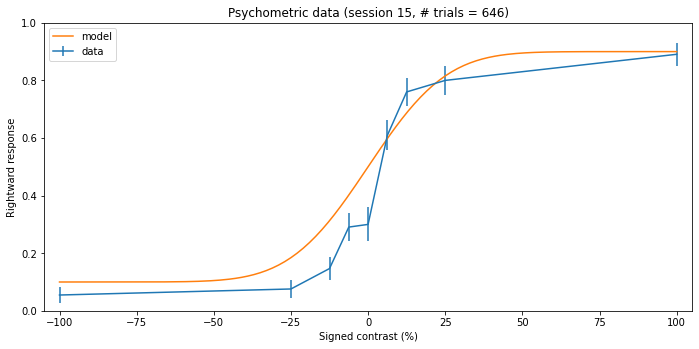

In [16]:
theta0 = (0,20,0.2,0.5) # Arbitrary parameter values - try different ones
session_num = 15
fig = plt.figure(figsize=(9,4))
ax = plot_psychometric_data(df,session_num)
psychofun_plot(theta0,ax)
plt.show()

We now define the log likelihood function of the psychometric function model for a given dataset and model parameter vector, $\log p(\text{data}|\mathbf{\theta})$.

In [17]:
def psychofun_loglike(theta,df):
    """Log-likelihood for psychometric function model"""
    s_vec = df['signed_contrast'] # Stimulus values
    r_vec = df['response_choice']  # Responses
    
    p_right = psychofun(theta,s_vec)
    
    # Compute summed log likelihood for all rightwards and leftwards responses
    loglike = np.sum(np.log(p_right[r_vec == 1])) + np.sum(np.log(1 - p_right[r_vec == -1]))

    return loglike

Now try to get the best fit for this session, as we did before, but by finding better and better values of the log-likelihood.

Log-likelihood value: -356.591


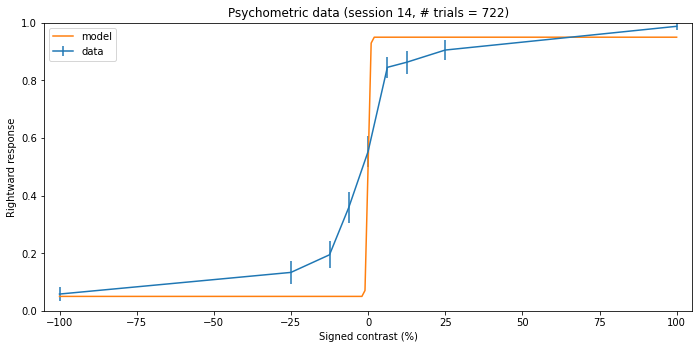

In [18]:
session_num = 14 # Let's use a different session

theta0 = (0,0.5,0.1,0.5) 

ll = psychofun_loglike(theta0,df[df['session_num'] == session_num])
print('Log-likelihood value: ' + "{:.3f}".format(ll))

fig = plt.figure(figsize=(9,4))
ax = plot_psychometric_data(df,session_num)
psychofun_plot(theta0,ax)
plt.show()

**Maximum-likelihood estimation:**

In this section, we are going to estimate model parameters (aka fit our models) by maximizing the log-likelihood. By convention in optimization, we are going to *minimize* the negative log-likelihood.

Before running the optimization, we define the *hard* lower and upper bounds for the parameters. If the optimization algorithm supports constrained (bound) optimization, it will never go outside the hard bounds. We also define informally the *plausible* bounds as the range of parameters that we would expect to see. We are going to use the plausible range to initialize the problem later.

In [19]:
# Define hard parameter bounds
lb = np.array([-100,1,0,0])
ub = np.array([100,100,1,1])
bounds = [lb,ub]

# Define plausible range
plb = np.array([-25,5,0.05,0.2])
pub = np.array([25,25,0.40,0.8])

# Pick session data
# session_num = 14
# df_session = df[df['session_num'] == session_num]

# # Define objective function: negative log-likelihood
# opt_fun = lambda theta_: -psychofun_loglike(theta_,df_session)

opt_funs = []
for df_session in range(1,16):
  print(df_session)
  opt_funs.append(lambda theta_: -psychofun_loglike(theta_,df[df['session_num'] == session_num]))
print(opt_funs)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
[<function <lambda> at 0x7fb79379cf80>, <function <lambda> at 0x7fb7937af170>, <function <lambda> at 0x7fb7937af320>, <function <lambda> at 0x7fb7937af4d0>, <function <lambda> at 0x7fb7937af680>, <function <lambda> at 0x7fb7937af830>, <function <lambda> at 0x7fb7937af9e0>, <function <lambda> at 0x7fb7937afb90>, <function <lambda> at 0x7fb7937afd40>, <function <lambda> at 0x7fb7937afef0>, <function <lambda> at 0x7fb7937490e0>, <function <lambda> at 0x7fb793749290>, <function <lambda> at 0x7fb793749440>, <function <lambda> at 0x7fb7937495f0>, <function <lambda> at 0x7fb7937497a0>]


We are now going to run a *black-box* optimization algorithm called CMA-ES. For now we are going to run the optimization only once, but in general you should *always* run the optimization from multiple distinct starting points.

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
[<function <lambda> at 0x7fb79385f830>, <function <lambda> at 0x7fb79380df80>, <function <lambda> at 0x7fb79380d170>, <function <lambda> at 0x7fb79380d320>, <function <lambda> at 0x7fb79380d290>, <function <lambda> at 0x7fb79380db90>, <function <lambda> at 0x7fb7937f0e60>, <function <lambda> at 0x7fb7937f0b90>, <function <lambda> at 0x7fb79383b4d0>, <function <lambda> at 0x7fb79383b050>, <function <lambda> at 0x7fb78b6c00e0>, <function <lambda> at 0x7fb78b6c0a70>, <function <lambda> at 0x7fb78b6c0ef0>, <function <lambda> at 0x7fb78b6c0170>, <function <lambda> at 0x7fb78b6c0f80>]
1
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=949972, Thu Nov 25 19:17:21 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.462145683870006e+02 1.0e+00 5.38e-01  5e-01  6e-01 0:00.0
    2     16 3.949821934886307e+02 1.6e+00 4.91e-01  4e-01  6e-01 0:00.0
    3     24 3.548007413608508e+02 1.7e+00 4.49e-01  3e-01  5e-01 0:

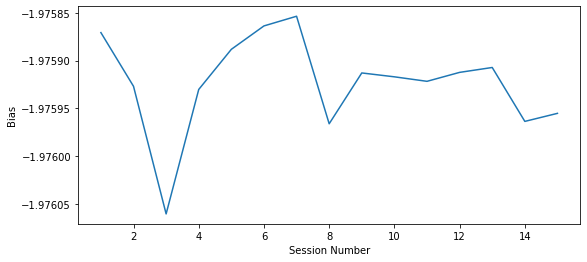

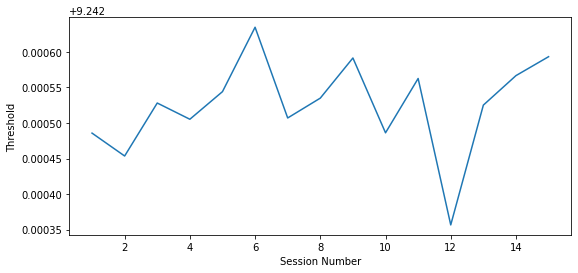

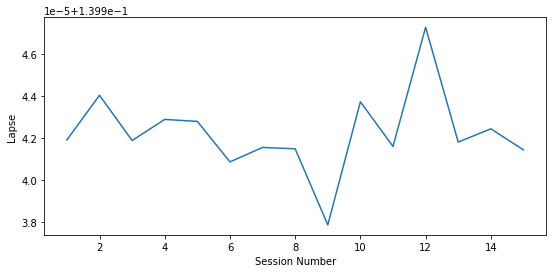

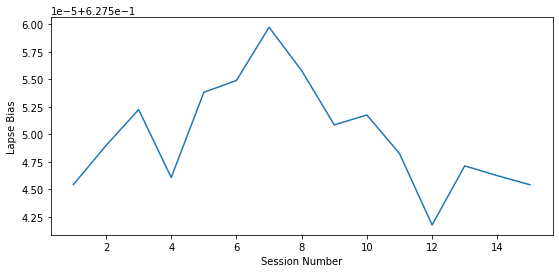

In [25]:
# # Generate random starting point for the optimization inside the plausible box
# theta0 = np.random.uniform(low=plb,high=pub) 
# print(theta0)
# # Initialize CMA-ES algorithm
# opts = cma.CMAOptions()
# opts.set("bounds",bounds)
# opts.set("tolfun",1e-5)

# # Run optimization
# res = cma.fmin(opt_fun, theta0, 0.5, opts)

# print('')
# print('Returned parameter vector: ' + str(res[0]))
# print('Negative log-likelihood at solution: ' + str(res[1]))

# fig = plt.figure(figsize=(9,4))
# ax = plot_psychometric_data(df_session,session_num)
# psychofun_plot(res[0],ax)
# plt.show()

lb = np.array([-100,1,0,0])
ub = np.array([100,100,1,1])
bounds = [lb,ub]

# Define plausible range
plb = np.array([-25,5,0.05,0.2])
pub = np.array([25,25,0.40,0.8])

# Pick session data
# session_num = 14
# df_session = df[df['session_num'] == session_num]

# # Define objective function: negative log-likelihood
# opt_fun = lambda theta_: -psychofun_loglike(theta_,df_session)

opt_funs = []
for df_session in range(1,16):
  print(df_session)
  opt_funs.append(lambda theta_: -psychofun_loglike(theta_,df[df['session_num'] == session_num]))
print(opt_funs)

# Generate random starting point for the optimization inside the plausible box
theta0 = np.random.uniform(low=plb,high=pub) 
# Initialize CMA-ES algorithm
opts = cma.CMAOptions()
opts.set("bounds",bounds)
opts.set("tolfun",1e-5)

data = pd.DataFrame(columns=['Session Number','Bias', 'Threshold', 'Lapse','Lapse Bias'])
# Run optimization
for opt_fun in opt_funs:
  print (opt_funs.index(opt_fun)+1)
  res = cma.fmin(opt_fun, theta0, 0.5, opts)
  data = data.append({'Session Number':int(opt_funs.index(opt_fun)+1),'Bias':res[0][0],'Threshold':res[0][1],'Lapse':res[0][2],'Lapse Bias':res[0][3]}, ignore_index=True)

for i in range(data.shape[1]-1):

  fig = plt.figure(figsize=(9,4))
  plt.xlabel("Session Number")
  plt.ylabel(f"{data.columns[i+1]}")
  plt.plot(data['Session Number'],data.iloc[:,i+1])
plt.show()

**Model comparison:**

We consider now a slightly more advanced model which includes time dependency by having the response in the current trial being influenced by the response in the previous trial. We adopt a simple model, `repeatlast`, in which the observer has a fixed chance of repeating the previous choice.

In [21]:
def psychofun_repeatlast_loglike(theta,df):
    """Log-likelihood for last-choice dependent psychometric function model"""
    s_vec = np.array(df['signed_contrast']) # Stimulus values
    r_vec = np.array(df['response_choice'])  # Responses
    
    p_last = theta[0] # Probability of responding as last choice
    theta_psy = theta[1:] # Standard psychometric function parameters
        
    p_right = psychofun(theta_psy,s_vec)
    
    # Starting from the 2nd trial, probability of responding equal to the last trial
    p_right[1:] = p_last*(r_vec[0:-1] == 1) + (1-p_last)*p_right[1:] 
    
    # Compute summed log likelihood for all rightwards and leftwards responses
    loglike = np.sum(np.log(p_right[r_vec == 1])) + np.sum(np.log(1 - p_right[r_vec == -1]))

    return loglike

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=1018181, Thu Nov 25 19:16:05 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.385578218960484e+02 1.0e+00 4.42e-01  4e-01  4e-01 0:00.0
    2     16 3.436835571631380e+02 1.3e+00 4.03e-01  3e-01  4e-01 0:00.0
    3     24 3.419989611472796e+02 1.3e+00 3.42e-01  3e-01  3e-01 0:00.0
  100    800 2.812099104804360e+02 8.1e+01 5.33e-01  1e-02  8e-01 0:00.8
  168   1344 2.804863985579651e+02 6.6e+01 6.44e-04  2e-06  1e-04 0:01.3
termination on tolfun=1e-05 (Thu Nov 25 19:16:07 2021)
final/bestever f-value = 2.804864e+02 2.804864e+02
incumbent solution: [0.15168565380666785, -2.1093767910936605, 7.1809753545584, 0.0569013568372686, 0.6223169507956088]
std deviation: [2.6042133370233853e-06, 8.80468143469709e-05, 0.00011150715398748071, 2.0465276639030577e-06, 1.7985032969107372e-05]

Returned parameter vector: [ 0.15168565 -2.10937679  7.18097535  0.05690136  0.62231695]
Negative log-likelihoo

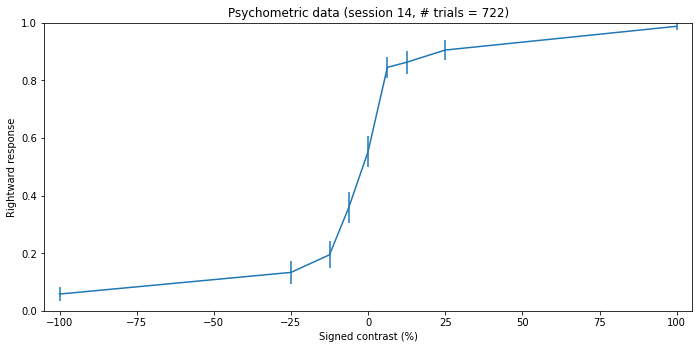

In [22]:
lb = np.array([0,-100,1,0,0])
ub = np.array([1,100,100,1,1])
bounds = [lb,ub]

plb = np.array([0.05,-25,5,0.05,0.2])
pub = np.array([0.2,25,25,0.45,0.8])

df_session = df[df['session_num'] == session_num]
# df_session = df[(df['session_num'] == session_num) & (df['trial_num'] > 300)]
opt_fun = lambda theta_: -psychofun_repeatlast_loglike(theta_,df_session)

theta0 = np.random.uniform(low=plb,high=pub)
opts = cma.CMAOptions()
opts.set("bounds",bounds)
opts.set("tolfun",1e-5)
res_repeatlast = cma.fmin(opt_fun, theta0, 0.5, opts)

print('')
print('Returned parameter vector: ' + str(res_repeatlast[0]))
print('Negative log-likelihood at solution: ' + str(res_repeatlast[1]))

fig = plt.figure(figsize=(9,4))
ax = plot_psychometric_data(df_session,session_num)
#psychofun_plot(res[0],ax)
plt.show()

We now calculate a few model simple comparison metrics, such as AIC and BIC, for the `basic` and `repeatlast` models.

In [24]:
Nmodels = 2
nll = np.zeros(Nmodels)
nparams = np.zeros(Nmodels)

results = [res,res_repeatlast] # Store all optimization output in a vector

for i in range(0,len(results)):
    nll[i] = results[i][1] # The optimization algorithm received the *negative* log-likelihood
    nparams[i] = len(results[i][0])

ntrials = len(df['signed_contrast'])

aic = 2*nll + 2*nparams
bic = 2*nll + nparams*np.log(ntrials)

print('Model comparison results (for all metrics, lower is better)\n')
print('Negative log-likelihoods: ' + str(nll))
print('AIC: ' + str(aic))
print('BIC: ' + str(bic))

NameError: ignored

### [Advanced] Optional model:

We consider next a more advanced model which includes explicit time dependency (the trials are not all the same), also known as *non-stationarity*. Note that this function is not coded very efficiently and runs quite slowly due to the `for` loop - it could be improved with vectorization.

In [ ]:
def psychofun_timevarying_loglike(theta,df):
    """Log-likelihood for time-varying psychometric function model"""
    s_vec = np.array(df['signed_contrast']) # Stimulus values
    r_vec = np.array(df['response_choice'])  # Responses
    
    Ntrials = len(s_vec)
    mu_vec = np.linspace(theta[0],theta[4],Ntrials)
    sigma_vec = np.linspace(theta[1],theta[5],Ntrials)
    lapse_vec = np.linspace(theta[2],theta[6],Ntrials)
    lapsebias_vec = np.linspace(theta[3],theta[7],Ntrials)
    
    p_right = np.zeros(Ntrials)
    
    for t in range(0,Ntrials):
        p_right[t] = psychofun([mu_vec[t],sigma_vec[t],lapse_vec[t],lapsebias_vec[t]],s_vec[t])
    
    # Compute summed log likelihood for all rightwards and leftwards responses
    loglike = np.sum(np.log(p_right[r_vec == 1])) + np.sum(np.log(1 - p_right[r_vec == -1]))

    return loglike

theta0 = (0,20,0.1,0.5,1,20,0.1,0.5)
ll = psychofun_timevarying_loglike(theta0,df[df['session_num'] == session_num])

In [ ]:
lb = np.array([-100,1,0,0,-100,1,0,0])
ub = np.array([100,100,1,1,100,100,1,1])
bounds = [lb,ub]

plb = np.array([-25,5,0.05,0.2,-25,5,0.05,0.2])
pub = np.array([25,25,0.45,0.8,25,25,0.45,0.8])

session_num = 14
df_session = df[df['session_num'] == session_num]
# df_session = df[(df['session_num'] == session_num) & (df['trial_num'] > 300)]
opt_fun = lambda theta_: -psychofun_timevarying_loglike(theta_,df_session)

theta0 = np.random.uniform(low=plb,high=pub)
opts = cma.CMAOptions()
opts.set("bounds",bounds)
opts.set("tolfun",1e-5)
res_time = cma.fmin(opt_fun, theta0, 0.5, opts)

print('')
print('Returned parameter vector: ' + str(res_time[0]))
print('Negative log-likelihood at solution: ' + str(res_time[1]))

fig = plt.figure(figsize=(9,4))
ax = plot_psychometric_data(df_session,session_num)
#psychofun_plot(res[0],ax)
plt.show()

## Your assignment

So far, we've expected the animal's choice data on a simple task, where the only relevant information is the stimulus (i.e. signed contrast). Below is data from a more complex version of the task, where the probability of the stimulus appearing on the left vs. right side changes between blocks.

In [ ]:
df_blocks = pd.read_csv('https://raw.githubusercontent.com/anne-urai/tics-2020-tutorial/master/data/KS014_biased.csv') 
df_blocks['signed_contrast'] = df_blocks.contrast * df_blocks.position

In [ ]:
df_blocks[df_blocks['session_num'] == 8]